National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Modern Decision Making: Applied Machine Learning

Final Project: Level of income prediction (binary classification)

Student: Andrei Batyrov (Fall2022)

Date: 21-Nov-2023

##### Table of Contents

[Description](#description)

1. [Data exploration](#data-exploration)

2. [Data preprocessing](#data-preprocessing)

3. [Model training](#model-training)

4. [Summary](#summary)

In [572]:
# Essential import
import json
import numpy as np
import pandas as pd
from scipy.stats.contingency import crosstab
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50) # set to larger value to see all the columns of pd.DF
seed = 0

Some helper functions.

In [534]:
def describe(series, kind, normalize=False):
    '''
    Print Pandas Series basic statistics.
    '''
    if kind not in ('num', 'cat'):
        raise ValueError("kind must be 'num' or 'cat'")
    if kind == 'cat':
        print(f'Data type: {str(series.dtype)}')
        print(f'{series.nunique():.0f} unique')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:.0f} nulls\033[0m')
        else:
            print(f'{nulls:.0f} nulls')
        print(f"{'':->20}")
        hist = series.value_counts(dropna=False, normalize=normalize).head(10).sort_values(ascending=False)
        #print(hist.to_string(max_rows=10, name=True))
        fig, ax = plt.subplots(1, 1, figsize=(3, 0.3*min(hist.shape[0], 10)))
        ax.barh(hist.index.astype(str), width=hist.values, color='white', edgecolor='C0', alpha=0.35, hatch='.'*6)
        ax.bar_label(ax.containers[0], label_type='edge', padding=5, fontsize=9)
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        for axis in fig.get_axes():
            spines = axis.spines
            spines['bottom'].set_color('white')
            spines['top'].set_color('white')
            spines['right'].set_color('white')
            spines['left'].set_color('darkgrey')
        return hist
    else: # kind == 'num'
        print(f'Data type: {str(series.dtype)}')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:.0f} nulls\033[0m')
        else:
            print(f'{nulls:.0f} nulls')
        print(f"Min = {series.min():,.2f}")
        print(f"Max = {series.max():,.2f}")
        print(f"Mean = {series.mean():,.2f}")
        print(f"Med = {series.median():,.2f}")
        print(f"Std = {series.std(ddof=1):,.2f}")

In [375]:
def percentile_interval(array, alpha):
    '''
    Return percentiles (boundaries) of `array`, as per the significance level `alpha`.
    '''
    boundaries = np.nanpercentile(array, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # Two-sided percentiles
    return boundaries

In [376]:
def run_chi2test(*sers, alpha=0.05):
    observed_df = pd.DataFrame(crosstab(*sers).count)
    df_index = sers[0].value_counts().index.sort_values()
    df_columns = sers[1].value_counts().index.sort_values()
    observed_df.index = df_index
    observed_df.columns = df_columns
    #print(observed_df.iloc[sorted(np.random.choice(observed_df.shape[0], min(5, observed_df.shape[0]), replace=False))].to_string(sparsify=False, formatters=[lambda x: f'{x:,}']*2))
    print(observed_df.to_string(sparsify=False, max_rows=5))
    print(f"{'':->20}")
    chi2_test_result = chi2_contingency(observed_df.values)
    p_value = chi2_test_result.pvalue
    print(f'{p_value = :.2e} ({alpha = })')
    print(f'`{sers[0].name}` and `{sers[1].name}` are _not_ independent') if p_value < alpha else print(f'`{sers[0].name}` and `{sers[1].name}` are independent')

In [604]:
def plot_hist(array, array2, bins, array2_perc, xlabel, title):
    '''
    Plot two histograms side by side.
    The left histogram plots all values of `array`.
    The right histogram plots within percentiles of `array2`, as per `array2_perc`.
    '''
    alpha = 1.0 - array2_perc / 100
    boundaries = percentile_interval(array, alpha)
    if array2 is not None:
        plt.figure(figsize=(12, 4))
        first = 1
        num_plots = 3
        plt.subplot(1, num_plots, first)
        plt.scatter(array, array2, color='C1', marker='x', alpha=0.25)
        k, b = np.polyfit(array, array2, deg=1)
        fitted_lr = k * array + b
        plt.plot(array, fitted_lr, color='C0', ls='--', label='Fitted LR')
        plt.xlabel(f'{xlabel}', size=10, family='monospace')
        plt.ylabel(f'Avg target', size=10, family='monospace')
        plt.ylim([array2.min(), array2.max()])
        plt.legend()
        plt.grid(lw=0.5)
    else:
        plt.figure(figsize=(8, 4))
        first = 0
        num_plots = 2
    
    plt.subplot(1, num_plots, first + 1)
    plt.hist(array, bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n(all values)', size=10, family='monospace')
    plt.ylabel('Count', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)

    plt.subplot(1, num_plots, first + 2)
    plt.hist(array[np.where((array >= boundaries[0]) & (array <= boundaries[1]))], bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n({array2_perc}%)', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)

    plt.suptitle(title, size=10, family='monospace')
    plt.tight_layout();

In [378]:
def plot_bar(df, x, y, xlabel, title, kind='vertical'):
    '''
    Plot bar plot, where `x` and `y` are column names of Pandas Dataframe `df`.
    '''
    if kind not in ('vertical', 'horizontal'):
        raise ValueError("kind must be 'vertical' or 'horizontal'")
    if kind == 'vertical':
        plt.figure(figsize=(6, 4))
        bars = plt.bar(range(df[x].shape[0]), df[y].values, width=0.25, align='center', color='white', alpha=0.75, hatch='.'*6)
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.xticks(range(df[x].shape[0]), df[x].values)
    else: # kind == 'horizontal'
        plt.figure(figsize=(6, 4))
        bars = plt.barh(range(df[x].shape[0]), df[y].values, height=0.25, align='center', color='white', alpha=0.75, hatch='.'*6)
        plt.gca().invert_yaxis()
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.yticks(range(df[x].shape[0]), df[x].values)
    for i in range(len(bars)):
        bars[i].set_edgecolor(f'C{i}')
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)
    plt.title(title, size=10, family='monospace');

In [379]:
def predict_partial(X, feature_name, estimator, kind, grid_size=10, ice_perc=95, feat_perc=95):
    '''
    Calculate partial predictions for one feature with name `feature_name` in Pandas Dataframe `X`.
    Estimator can by any object that has `predict` method: model, pipeline.
    `grid_size` controls the number of values of a feature to generate predictions for.
    Return Pandas DataFrame with:
    - feature values used for predictions, 
    - mean predictions -- this is partial dependence (PD), 
    - Individual Conditional Expectation (ICE) low and high percentiles, as per `ice_perc`
    '''
    if kind not in ('num', 'cat', 'ord'):
        raise ValueError("kind must be 'num', 'cat' or 'ord'")
    grid_size = min(X[feature_name].nunique(), grid_size)
    feature_values = []
    feature_pred_means = []
    ice_los = []
    ice_his = []
    if kind == 'num':
        # For numerical features we can use either all values in its space or bounded by some percentiles
        feature_space = np.linspace(*percentile_interval(X[feature_name], alpha=1.0-feat_perc/100), grid_size)
    elif kind == 'cat':
        feature_space = X[feature_name].unique()[::X[feature_name].nunique() // grid_size]
    else: # kind == 'ord'
        feature_space = X[feature_name].sort_values().unique()[::X[feature_name].nunique() // grid_size]
    for feature_value in feature_space:
        feature_values.append(feature_value)
        feature_new = pd.Series([feature_value] * X.shape[0], name=feature_name) # Fix one feature value for all observations
        # First drop the whole feature, then concatenate its new values, i.e. replace the feature vector
        # Predict with this replaced feature vector
        feature_pred = estimator.predict(pd.concat([X.drop(columns=[feature_name]).reset_index(drop=True), feature_new], axis=1))
        feature_pred_mean = feature_pred.mean() # Partial Dependence
        feature_pred_means.append(feature_pred_mean)
        ice_lo, ice_hi = percentile_interval(feature_pred, alpha=1.0-ice_perc/100) # ICE boundaries
        ice_los.append(ice_lo)
        ice_his.append(ice_hi)
    return pd.DataFrame({'Value': feature_values, 'Pred_mean': feature_pred_means, 'ICE_lo': ice_los, 'ICE_hi': ice_his})

---
# <a id="description"></a>Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/dataset/117/census+income+kdd

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### <a id="data-exploration"></a>[25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?

In [380]:
with open('columns.json', 'r') as fh:
    cols = json.load(fh)['columns']
cols[:5]

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education']

Load the train data. Note that there are observations with values represented by `?` in some columns. We will treat them as missing/unknown values in our analysis.

In [551]:
data = pd.read_csv('census-income.data', na_values='?', skipinitialspace=True)
data.columns = cols
# Take a look at some 3 random observations
data.iloc[sorted(np.random.choice(data.shape[0], 3, replace=False))]

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran admin,veterans benefits,weeks worked in year,year,target
55737,35,Private,45,14,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Other professional services,Technicians and related support,Other,All other,Female,No,Not in universe,Children or Armed Forces,0,0,0,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,3062.12,Nonmover,Nonmover,Nonmover,Yes,Not in universe,4,Not in universe,Iran,Iran,Iran,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
88453,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,Central or South American,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1389.30,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,Columbia,Ecuador,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
138893,12,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1419.55,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [382]:
data.shape

(199522, 42)

First, let's examine the target variable.

Data type: object
2 unique
0 nulls
--------------------


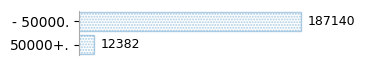

In [555]:
target = 'target'
hist = pd.DataFrame(describe(data[target], 'cat')).reset_index()
#plot_bar(hist, target, 'count', 'Level of income', 'Distribution of target')

We can clearly see that the target variable takes only two values (levels of income). Also, note that the distribution of the target is not uniform, i.e. we have highly imbalanced data. Therefore, we __cannot use__ the `accuracy score` for this task to evaluate our classifier(s). Indeed, let's construct a naive classifier that will always predict the most frequent level of income which is "`- 50000.`", and compute the accuracy score for such predictions.

In [384]:
y_pred_naive = np.ones_like(data[target]) * hist[target][0]
print(f'Predicted level of income: {y_pred_naive[:5]} ...')
print(f"Naive classifier's accuracy = {accuracy_score(data[target], y_pred_naive):.2%}")

Predicted level of income: ['- 50000.' '- 50000.' '- 50000.' '- 50000.' '- 50000.'] ...
Naive classifier's accuracy = 93.79%


Is the task solved? Well, if we're only interested in reporting the frequency of the "`- 50000.`" income level, regardless of any other features in our data, then yes. However, __let's assume that we're interested in predicting the positive effect__ from observing our features. In other words, we would like to understand the profile of those participants who earn more. Let predicting the level of income "`50000+.`" be the positive effect (positive `Class 1`), and predicting the level of income "`- 50000.`" be the negative effect (negative `Class 0`). Thus, we will be solving a binary classification problem in this task. Since, we're interested in the positive class, we will focus on the `precision`, `recall (tpr)`, and `f1 score` metrics to evaluate how well our classifier(s) can predict the positive class. In addition, we will also look at the `tpr` and `fpr` metrics to evaluate how well our classifier(s) can distinguish between the positive and negative classes.

Now, let's encode the target variable as `1` and `0` for the further analysis. Don' forget to check that the encoding is done correctly.

Data type: int32
2 unique
0 nulls
--------------------


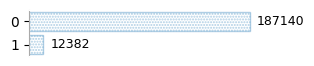

In [556]:
target_label_enc = LabelEncoder()
data[target] = target_label_enc.fit_transform(data[target])
hist = pd.DataFrame(describe(data[target], 'cat')).reset_index()
#plot_bar(hist, target, 'count', 'Target class', 'Distribution of target')

---
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step

Let's choose the __Stratified K-Fold cross-validation strategy__ applied on the train data. It is a variation of the K-Fold cross-validation strategy that uses stratified folds. This strategy allows to keep proportions of observations selected into folds, as per the target class distribution, thus taking into account the imbalance of our data.

The advantages of this strategy:
- it does not require any additional validation data, since the validation samples are constructed from the train data itself;
- it does not require any preprocessing of the train data, since the folds are created during the very process of cross-validation on the fly.

However, this strategy has disadvantages too:
- since one of the folds is used for validation, not all train data is used for fitting the model in every training round;
- the model (or pipeline) has to be trained as many times as there are folds, which takes time.

---
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

Now, let's look closer at our predictors (features).
- for categorical and ordinal features we will check association with the target by using $\chi^2$-test. For simplicity, we'll ignore the $\chi^2$-test's requirement of more than 5 counts in the contingency table cells.
- for numerical features we will check Pearson's correlation with the target (linear). However, since the target is binary it does not make much sense to compute the correlation coefficient directly. Instead, we'll use one of disadvantages of the target encoding technique which is target leakage -- we will check the correlation between a numerical feature and its target-encoded copy. Since, our numerical features are integers (or they can be binned, anyway), we can divide them in separate "categories" corresponding to their discrete values. Now, target encoding returns the average target value for each "category" of a feature, which is the probability of class 1, in fact. That is, it converts our binary target into a real variable. And we can estimate the correlation.

In [575]:
feat_eng_target_enc = TargetEncoder() # Target encoder for this section

In [ ]:
data.drop(columns=target).dtypes.value_counts(normalize=False)

In [387]:
data.drop(columns=target).select_dtypes(int).columns

Index(['age', 'detailed industry recode', 'detailed occupation recode',
       'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'num persons worked for employer',
       'own business or self employed', 'veterans benefits',
       'weeks worked in year', 'year'],
      dtype='object')

In [388]:
data.drop(columns=target).columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'instance weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
 

In [389]:
num_incl_cols, num_excl_cols, cat_incl_cols, cat_excl_cols, ord_incl_cols, ord_excl_cols = [], [], [], [], [], []

Pearson corr coef = 0.54
Data type: int64
0 nulls
Min = 0.00
Max = 90.00
Mean = 34.49
Med = 33.00
Std = 22.31


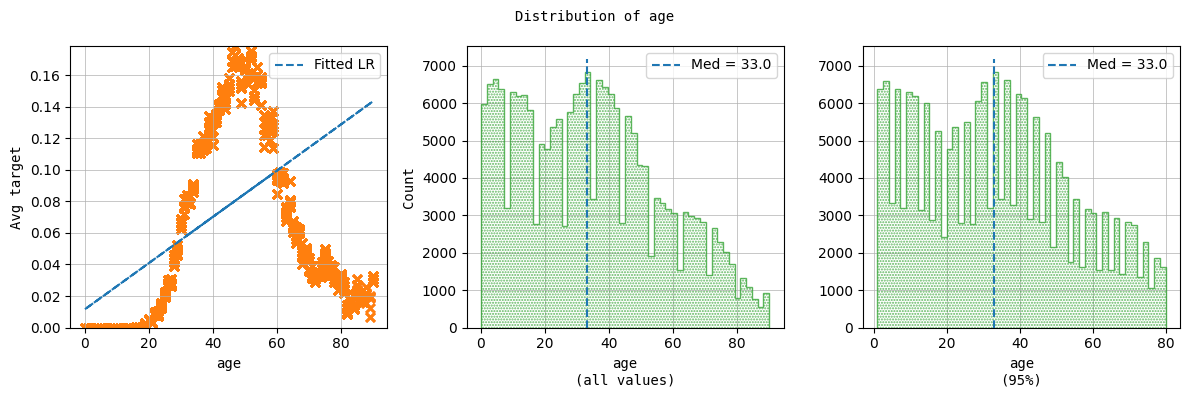

In [607]:
# 1. Age
feature_name = 'age'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`age` looks like a continuous variable. Looks like middle age participants earn more than younger and older ones. We will use this feature in our model.

In [391]:
num_incl_cols.append(feature_name)

Data type: object
9 unique
0 nulls
--------------------


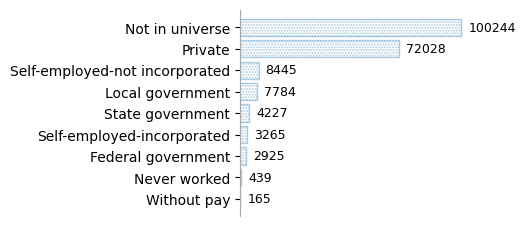

In [537]:
# 2. Class of worker
feature_name = 'class of worker'
_ = describe(data[feature_name], 'cat')

In [393]:
run_chi2test(data[feature_name], data[target])

target                 0    1
class of worker              
Federal government  2328  597
Local government    6937  847
...                  ...  ...
State government    3742  485
Without pay          164    1
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`class of worker` and `target` are _not_ independent


We have confirmed that `class of worker` and target are not independent indeed, thus we will use this feature in our model.

In [394]:
cat_incl_cols.append(feature_name)

Data type: int64
52 unique
0 nulls
--------------------


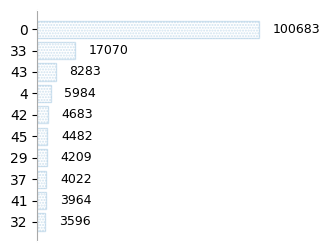

In [395]:
# 3. Detailed industry recode
feature_name = 'detailed industry recode'
_ = describe(data[feature_name], 'cat')

In [396]:
run_chi2test(data[feature_name], data[target])

target                        0    1
detailed industry recode            
0                         99777  906
1                           780   47
...                         ...  ...
50                         1407  297
51                           28    8
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed industry recode` and `target` are _not_ independent


We have confirmed that `detailed industry recode` and target are not independent indeed, thus we will use this feature in our model.

In [397]:
cat_incl_cols.append(feature_name)

Data type: int64
47 unique
0 nulls
--------------------


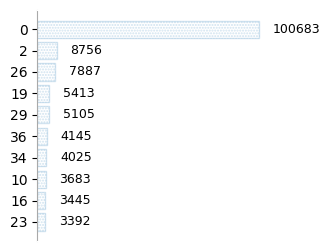

In [398]:
# 4. Detailed occupation recode
feature_name = 'detailed occupation recode'
_ = describe(data[feature_name], 'cat')

In [399]:
run_chi2test(data[feature_name], data[target])

target                          0    1
detailed occupation recode            
0                           99777  906
1                             411  133
...                           ...  ...
45                            152   20
46                             28    8
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed occupation recode` and `target` are _not_ independent


We have confirmed that `detailed occupation recode` and target are not independent indeed, thus we will use this feature in our model.

In [400]:
cat_incl_cols.append(feature_name)

Data type: object
17 unique
0 nulls
--------------------


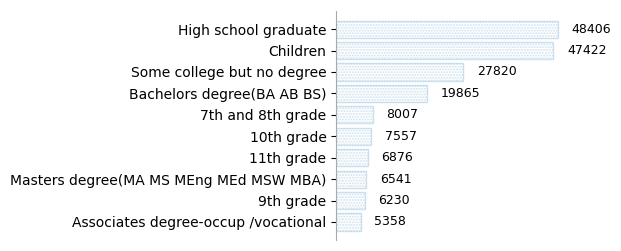

In [401]:
# 5. Education
feature_name = 'education'
_ = describe(data[feature_name], 'cat')

In [402]:
run_chi2test(data[feature_name], data[target])

target                                      0     1
education                                          
10th grade                               7495    62
11th grade                               6806    70
...                                       ...   ...
Prof school degree (MD DDS DVM LLB JD)    824   969
Some college but no degree              26033  1787
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`education` and `target` are _not_ independent


We have confirmed that `education` and target are not independent indeed, thus we will use this feature in our model.

In [403]:
cat_incl_cols.append(feature_name)

Pearson corr coef = 0.10
Data type: int64
0 nulls
Min = 0.00
Max = 9,999.00
Mean = 55.43
Med = 0.00
Std = 274.90


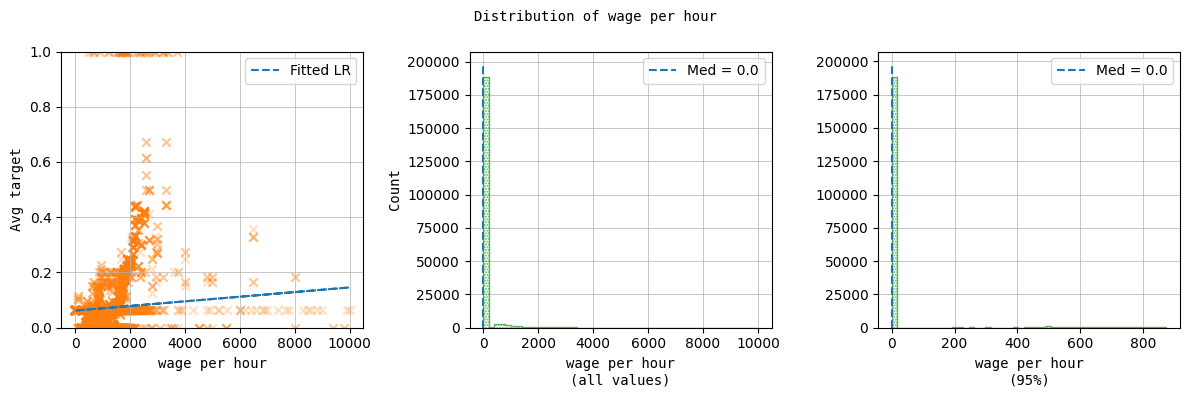

In [606]:
# 6. Wage per hour
feature_name = 'wage per hour'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Data type: int64
1240 unique
0 nulls
--------------------


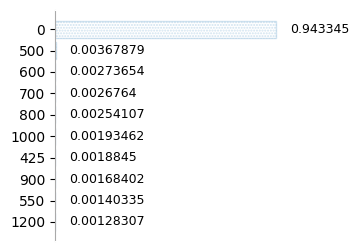

In [405]:
_ = describe(data[feature_name], 'cat', normalize=True)

`wage per hour` looks like a continuous variable. It is almost not linearly correlated with the target. It has over 94% of the same value of 0.0, that is the feature does not variate much, which does not add any valuable information to our model. Thus, we will not use this feature in our model.

In [406]:
num_excl_cols.append(feature_name)

Data type: object
3 unique
0 nulls
--------------------


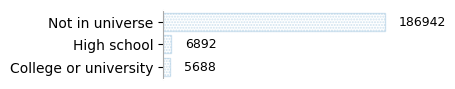

In [407]:
# 7. Enroll in edu inst last wk
feature_name = 'enroll in edu inst last wk'
_ = describe(data[feature_name], 'cat')

In [408]:
run_chi2test(data[feature_name], data[target])

target                           0      1
enroll in edu inst last wk               
College or university         5663     25
High school                   6887      5
Not in universe             174590  12352
--------------------
p_value = 3.02e-179 (alpha = 0.05)
`enroll in edu inst last wk` and `target` are _not_ independent


We have confirmed that `enroll in edu inst last wk` and target are not independent indeed, thus we will use this feature in our model. Interestingly, there are high school students who earn more than 50,000.

In [409]:
cat_incl_cols.append(feature_name)

Data type: object
7 unique
0 nulls
--------------------


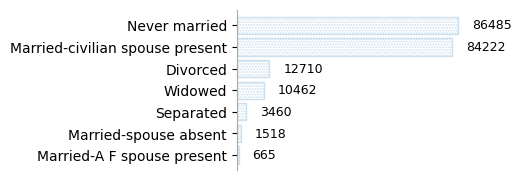

In [410]:
# 8. Marital stat
feature_name = 'marital stat'
_ = describe(data[feature_name], 'cat')

In [411]:
run_chi2test(data[feature_name], data[target])

target                          0     1
marital stat                           
Divorced                    11644  1066
Married-A F spouse present    650    15
...                           ...   ...
Separated                    3302   158
Widowed                     10132   330
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`marital stat` and `target` are _not_ independent


We have confirmed that `marital stat` and target are not independent indeed, thus we will use this feature in our model.

In [412]:
cat_incl_cols.append(feature_name)

Data type: object
24 unique
0 nulls
--------------------


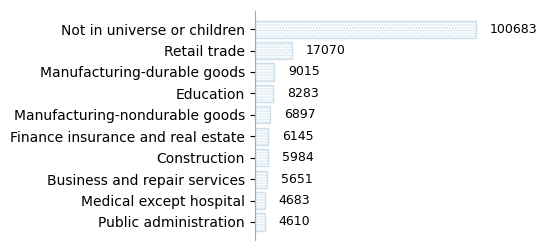

In [413]:
# 9. Major industry code
feature_name = 'major industry code'
_ = describe(data[feature_name], 'cat')

In [414]:
run_chi2test(data[feature_name], data[target])

target                              0    1
major industry code                       
Agriculture                      2845  178
Armed Forces                       28    8
...                               ...  ...
Utilities and sanitary services   922  256
Wholesale trade                  3044  552
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`major industry code` and `target` are _not_ independent


We have confirmed that `major industry code` and target are not independent indeed, thus we will use this feature in our model.

In [415]:
cat_incl_cols.append(feature_name)

Data type: object
15 unique
0 nulls
--------------------


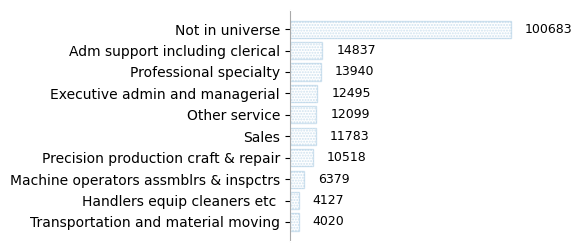

In [416]:
# 10. Major occupation code
feature_name = 'major occupation code'
_ = describe(data[feature_name], 'cat')

In [417]:
run_chi2test(data[feature_name], data[target])

target                                  0    1
major occupation code                         
Adm support including clerical      14391  446
Armed Forces                           28    8
...                                   ...  ...
Technicians and related support      2657  361
Transportation and material moving   3761  259
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`major occupation code` and `target` are _not_ independent


We have confirmed that `major occupation code` and target are not independent indeed, thus we will use this feature in our model.

In [418]:
cat_incl_cols.append(feature_name)

Data type: object
5 unique
0 nulls
--------------------


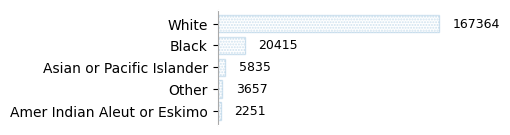

In [419]:
# 11. Race
feature_name = 'race'
_ = describe(data[feature_name], 'cat')

In [420]:
run_chi2test(data[feature_name], data[target])

target                            0      1
race                                      
Amer Indian Aleut or Eskimo    2202     49
Asian or Pacific Islander      5405    430
Black                         19875    540
Other                          3566     91
White                        156092  11272
--------------------
p_value = 1.15e-147 (alpha = 0.05)
`race` and `target` are _not_ independent


We have confirmed that `race` and target are not independent indeed, thus we will use this feature in our model.

In [421]:
cat_incl_cols.append(feature_name)

Data type: object
9 unique
874 nulls
--------------------


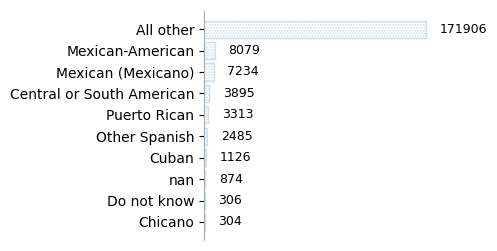

In [422]:
# 12. Hispanic origin
feature_name = 'hispanic origin'
_ = describe(data[feature_name], 'cat')

In [423]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                          0      1
hispanic origin                         
All other                  160139  11767
Central or South American    3815     80
...                           ...    ...
Puerto Rican                 3245     68
Unknown                       817     57
--------------------
p_value = 2.22e-196 (alpha = 0.05)
`hispanic origin` and `target` are _not_ independent


We have confirmed that `hispanic origin` and target are not independent indeed, thus we will use this feature in our model.

In [424]:
cat_incl_cols.append(feature_name)

Data type: object
2 unique
0 nulls
--------------------


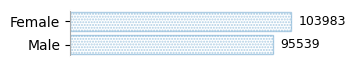

In [585]:
# 13. Sex
feature_name = 'sex'
_ = describe(data[feature_name], 'cat')

In [426]:
run_chi2test(data[feature_name], data[target])

target       0     1
sex                 
Female  101320  2663
Male     85820  9719
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`sex` and `target` are _not_ independent


We have confirmed that `sex` and target are not independent indeed, thus we will use this feature in our model. Interestingly, men look to earn more than women.

In [427]:
cat_incl_cols.append(feature_name)

Data type: object
3 unique
0 nulls
--------------------


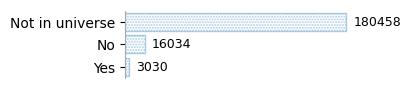

In [586]:
# 14. Member of a labor union
feature_name = 'member of a labor union'
_ = describe(data[feature_name], 'cat')

In [429]:
run_chi2test(data[feature_name], data[target])

target                        0      1
member of a labor union               
No                        14212   1822
Not in universe          170310  10148
Yes                        2618    412
--------------------
p_value = 1.99e-244 (alpha = 0.05)
`member of a labor union` and `target` are _not_ independent


We have confirmed that `member of a labor union` and target are not independent indeed, thus we will use this feature in our model.

In [430]:
cat_incl_cols.append(feature_name)

Data type: object
6 unique
0 nulls
--------------------


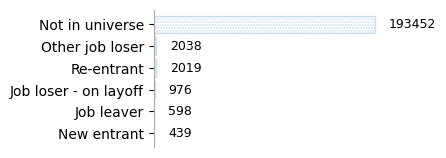

In [431]:
# 15. Reason for unemployment
feature_name = 'reason for unemployment'
_ = describe(data[feature_name], 'cat')

In [432]:
run_chi2test(data[feature_name], data[target])

target                      0   1
reason for unemployment          
Job leaver                574  24
Job loser - on layoff     954  22
...                       ...  ..
Other job loser          1939  99
Re-entrant               1996  23
--------------------
p_value = 1.01e-31 (alpha = 0.05)
`reason for unemployment` and `target` are _not_ independent


We have confirmed that `reason for unemployment` and target are not independent indeed, thus we will use this feature in our model.

In [433]:
cat_incl_cols.append(feature_name)

Data type: object
8 unique
0 nulls
--------------------


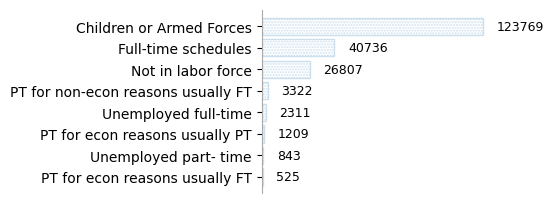

In [434]:
# 16. Full or part time employment stat
feature_name = 'full or part time employment stat'
_ = describe(data[feature_name], 'cat')

In [435]:
run_chi2test(data[feature_name], data[target])

target                                  0     1
full or part time employment stat              
Children or Armed Forces           117895  5874
Full-time schedules                 35370  5366
...                                   ...   ...
Unemployed full-time                 2228    83
Unemployed part- time                 825    18
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`full or part time employment stat` and `target` are _not_ independent


We have confirmed that `full or part time employment stat` and target are not independent indeed, thus we will use this feature in our model.

In [436]:
cat_incl_cols.append(feature_name)

Pearson corr coef with target = 0.65
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 434.72
Med = 0.00
Std = 4,697.54


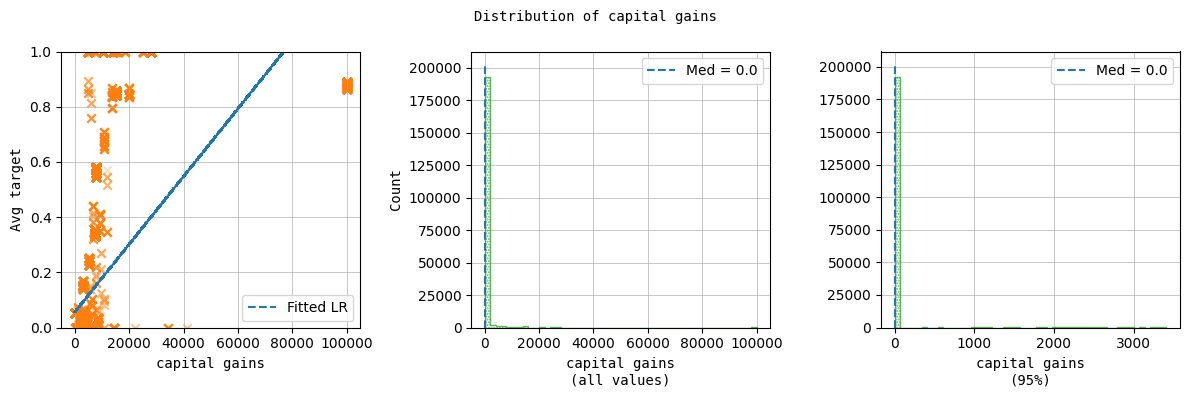

In [587]:
# 17. Capital gains
feature_name = 'capital gains'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Data type: int64
132 unique
0 nulls
--------------------


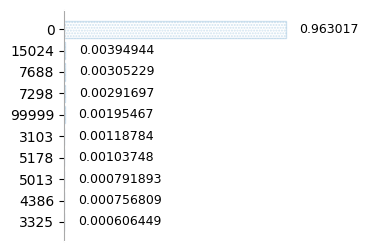

In [438]:
_ = describe(data[feature_name], 'cat', normalize=True)

`capital gains` looks like a continuous variable. It is rather loosely linearly correlated with the target. It has over 96% of the same value of 0.0, that is the feature does not variate much, which does not add any valuable information. Thus, we will not use this feature in our model.

In [439]:
num_excl_cols.append(feature_name)

Pearson corr coef with target = 0.59
Data type: int64
0 nulls
Min = 0.00
Max = 4,608.00
Mean = 37.31
Med = 0.00
Std = 271.90


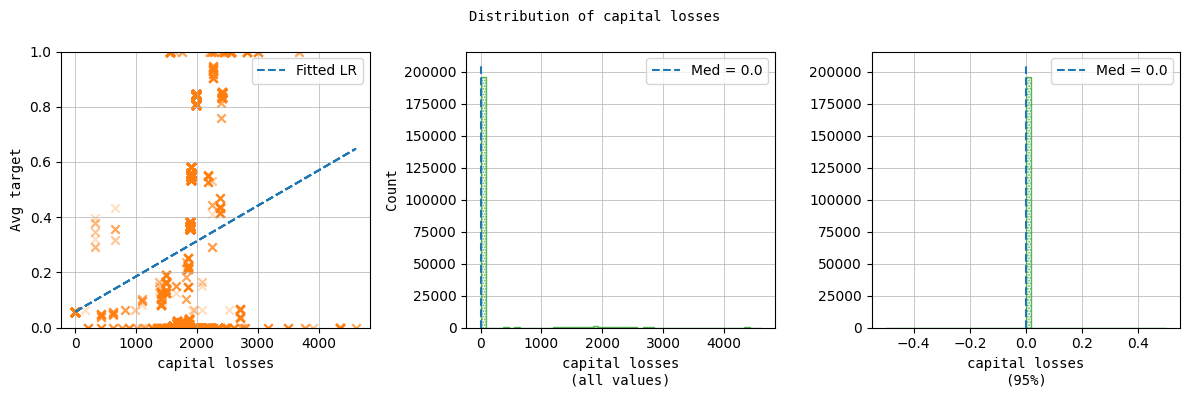

In [588]:
# 18. Capital losses
feature_name = 'capital losses'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Data type: int64
113 unique
0 nulls
--------------------


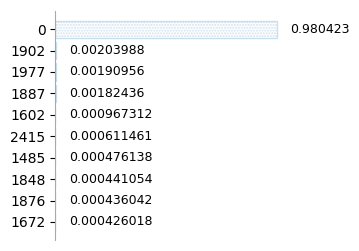

In [441]:
_ = describe(data[feature_name], 'cat', normalize=True)

`capital losses` looks like a continuous variable. It is almost not linearly correlated with the target. It has over 98% of the same value of 0.0, that is the feature does not variate much, which does not add any valuable information. Thus, we will not use this feature in our model.

In [442]:
num_excl_cols.append(feature_name)

Pearson corr coef with target = 0.49
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 197.53
Med = 0.00
Std = 1,984.17


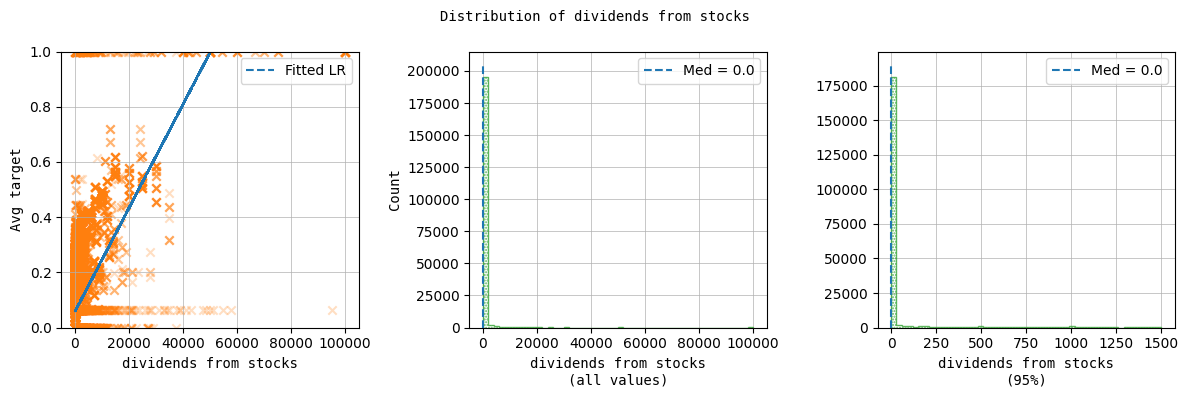

In [589]:
# 19. Dividends from stocks
feature_name = 'dividends from stocks'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Data type: int64
1478 unique
0 nulls
--------------------


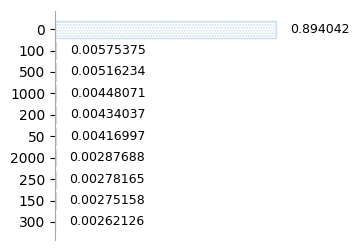

In [444]:
_ = describe(data[feature_name], 'cat', normalize=True)

`dividends from stocks` looks like a continuous variable. It is almost not linearly correlated with the target. It has over 89% of the same value of 0.0, that is the feature does not variate much, which does not add any valuable information. Thus, we will not use this feature in our model.

In [445]:
num_excl_cols.append(feature_name)

Data type: object
6 unique
0 nulls
--------------------


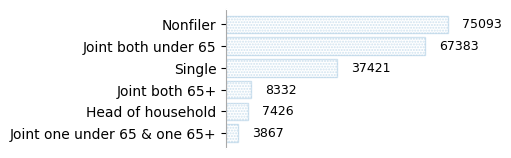

In [446]:
# 20. Tax filer stat
feature_name = 'tax filer stat'
_ = describe(data[feature_name], 'cat')

In [447]:
run_chi2test(data[feature_name], data[target])

target                 0     1
tax filer stat                
Head of household   6978   448
Joint both 65+      7882   450
...                  ...   ...
Nonfiler           75058    35
Single             35126  2295
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`tax filer stat` and `target` are _not_ independent


We have confirmed that `tax filer stat` and target are not independent indeed, thus we will use this feature in our model.

In [448]:
cat_incl_cols.append(feature_name)

Data type: object
6 unique
0 nulls
--------------------


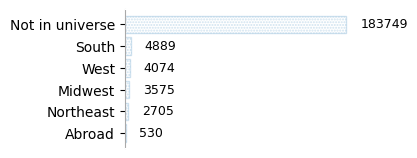

In [449]:
# 21. Region of previous residence
feature_name = 'region of previous residence'
_ = describe(data[feature_name], 'cat')

In [450]:
run_chi2test(data[feature_name], data[target])

target                           0    1
region of previous residence           
Abroad                         512   18
Midwest                       3466  109
...                            ...  ...
South                         4705  184
West                          3914  160
--------------------
p_value = 8.16e-35 (alpha = 0.05)
`region of previous residence` and `target` are _not_ independent


We have confirmed that `region of previous residence` and target are not independent indeed, thus we will use this feature in our model.

In [451]:
cat_incl_cols.append(feature_name)

Data type: object
50 unique
708 nulls
--------------------


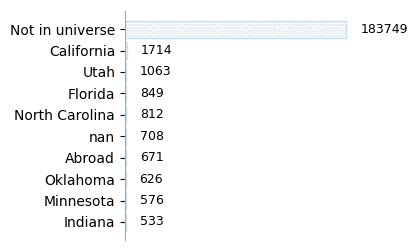

In [452]:
# 22. State of previous residence
feature_name = 'state of previous residence'
_ = describe(data[feature_name], 'cat')

In [453]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                         0   1
state of previous residence         
Abroad                       648  23
Alabama                      210   6
...                          ...  ..
Wisconsin                    100   5
Wyoming                      231  10
--------------------
p_value = 3.05e-23 (alpha = 0.05)
`state of previous residence` and `target` are _not_ independent


We have confirmed that `state of previous residence` and target are not independent indeed, thus we will use this feature in our model.

In [454]:
cat_incl_cols.append(feature_name)

Data type: object
38 unique
0 nulls
--------------------


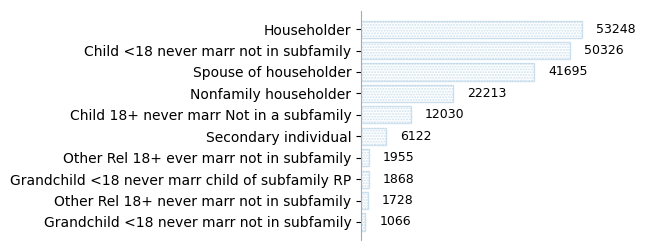

In [455]:
# 23. Detailed household and family stat
feature_name = 'detailed household and family stat'
_ = describe(data[feature_name], 'cat')

In [456]:
run_chi2test(data[feature_name], data[target])

target                                      0     1
detailed household and family stat                 
Child 18+ ever marr Not in a subfamily    990    23
Child 18+ ever marr RP of subfamily       659    12
...                                       ...   ...
Spouse of RP of unrelated subfamily        47     5
Spouse of householder                   39413  2282
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed household and family stat` and `target` are _not_ independent


We have confirmed that `detailed household and family stat` and target are not independent indeed, thus we will use this feature in our model.

In [457]:
cat_incl_cols.append(feature_name)

Data type: object
8 unique
0 nulls
--------------------


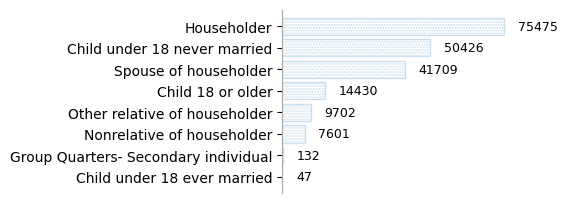

In [458]:
# 24. Detailed household summary in household
feature_name = 'detailed household summary in household'
_ = describe(data[feature_name], 'cat')

In [459]:
run_chi2test(data[feature_name], data[target])

target                                       0     1
detailed household summary in household             
Child 18 or older                        14304   126
Child under 18 ever married                 47     0
...                                        ...   ...
Other relative of householder             9616    86
Spouse of householder                    39427  2282
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed household summary in household` and `target` are _not_ independent


We have confirmed that `detailed household summary in household` and target are not independent indeed, thus we will use this feature in our model.

In [460]:
cat_incl_cols.append(feature_name)

Pearson corr coef with target = 0.03
Data type: float64
0 nulls
Min = 37.87
Max = 18,656.30
Mean = 1,740.38
Med = 1,618.31
Std = 993.77


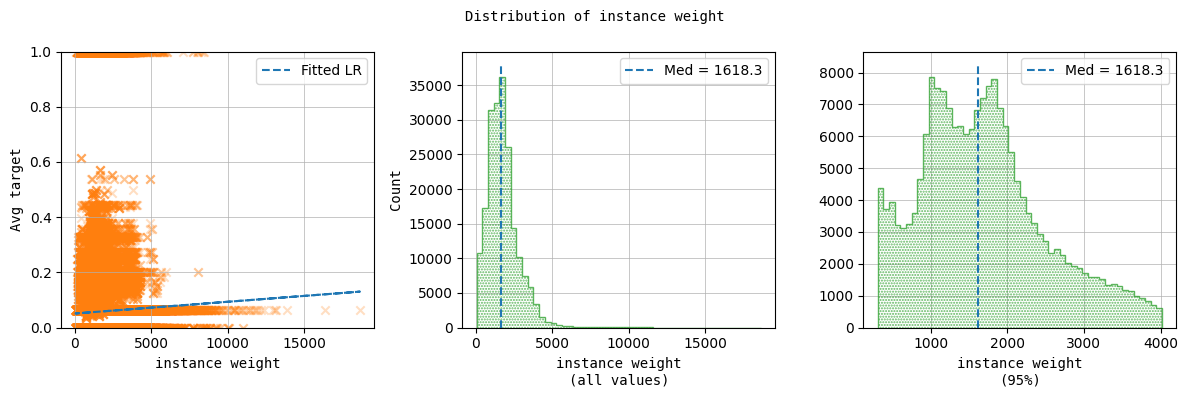

In [590]:
# 25. Instance weight
feature_name = 'instance weight'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`instance weight` looks like a continuous variable. It is almost not linearly correlated with the target. Note that as per the description of this dataset, this variable should _not_ be used in the classifiers, thus we will drop and not use this feature in our model.

In [462]:
data.drop(columns=feature_name, inplace=True)

Data type: object
9 unique
99695 nulls
--------------------


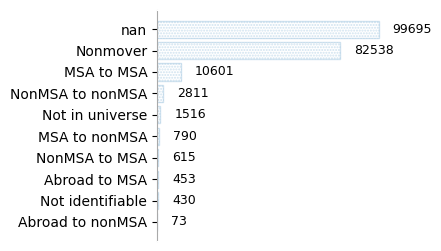

In [463]:
# 26. Migration code-change in msa
feature_name = 'migration code-change in msa'
_ = describe(data[feature_name], 'cat')

In [464]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                            0     1
migration code-change in msa             
Abroad to MSA                   435    18
Abroad to nonMSA                 73     0
...                             ...   ...
Not in universe                1516     0
Unknown                       93152  6543
--------------------
p_value = 5.35e-59 (alpha = 0.05)
`migration code-change in msa` and `target` are _not_ independent


We have confirmed that `migration code-change in msa` and target are not independent indeed, thus we will use this feature in our model. Note that this feature has around 50% of missing values.

In [465]:
cat_incl_cols.append(feature_name)

Data type: object
8 unique
99695 nulls
--------------------


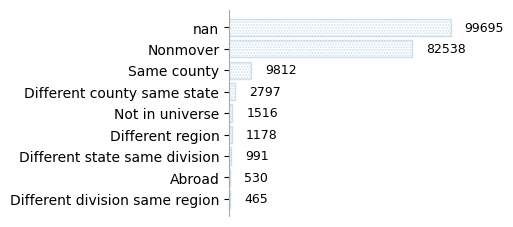

In [466]:
# 27. Migration code-change in reg
feature_name = 'migration code-change in reg'
_ = describe(data[feature_name], 'cat')

In [467]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                            0     1
migration code-change in reg             
Abroad                          512    18
Different county same state    2670   127
...                             ...   ...
Same county                    9484   328
Unknown                       93152  6543
--------------------
p_value = 1.34e-57 (alpha = 0.05)
`migration code-change in reg` and `target` are _not_ independent


We have confirmed that `migration code-change in reg` and target are not independent indeed, thus we will use this feature in our model. Note that this variable has around 50% of missing values.

In [468]:
cat_incl_cols.append(feature_name)

Data type: object
9 unique
99695 nulls
--------------------


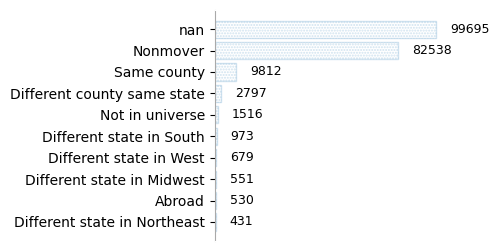

In [469]:
# 28. Migration code-move within reg
feature_name = 'migration code-move within reg'
_ = describe(data[feature_name], 'cat')

In [470]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                              0     1
migration code-move within reg             
Abroad                            512    18
Different county same state      2670   127
...                               ...   ...
Same county                      9484   328
Unknown                         93152  6543
--------------------
p_value = 8.62e-57 (alpha = 0.05)
`migration code-move within reg` and `target` are _not_ independent


We have confirmed that `migration code-move within reg` and target are not independent indeed, thus we will use this feature in our model. Note that this feature has around 50% of missing values.

In [471]:
cat_incl_cols.append(feature_name)

Data type: object
3 unique
0 nulls
--------------------


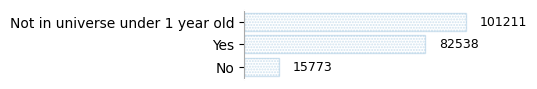

In [472]:
# 29. Live in this house 1 year ago
feature_name = 'live in this house 1 year ago'
_ = describe(data[feature_name], 'cat')

In [473]:
run_chi2test(data[feature_name], data[target])

target                                0     1
live in this house 1 year ago                
No                                15155   618
Not in universe under 1 year old  94668  6543
Yes                               77317  5221
--------------------
p_value = 1.70e-34 (alpha = 0.05)
`live in this house 1 year ago` and `target` are _not_ independent


We have confirmed that `live in this house 1 year ago` and target are not independent indeed, thus we will use this feature in our model.

In [474]:
cat_incl_cols.append(feature_name)

Data type: object
3 unique
99695 nulls
--------------------


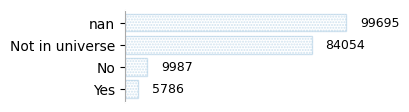

In [475]:
# 30. Migration prev res in sunbelt
feature_name = 'migration prev res in sunbelt'
_ = describe(data[feature_name], 'cat')

In [476]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                             0     1
migration prev res in sunbelt             
No                              9563   424
Not in universe                78833  5221
Unknown                        93152  6543
Yes                             5592   194
--------------------
p_value = 2.43e-36 (alpha = 0.05)
`migration prev res in sunbelt` and `target` are _not_ independent


We have confirmed that `migration prev res in sunbelt` and target are not independent indeed, thus we will use this feature in our model. Note that this variable has around 50% of missing values.

In [477]:
cat_incl_cols.append(feature_name)

Pearson corr coef with target = 0.94
Data type: int64
0 nulls
Min = 0.00
Max = 6.00
Mean = 1.96
Med = 1.00
Std = 2.37


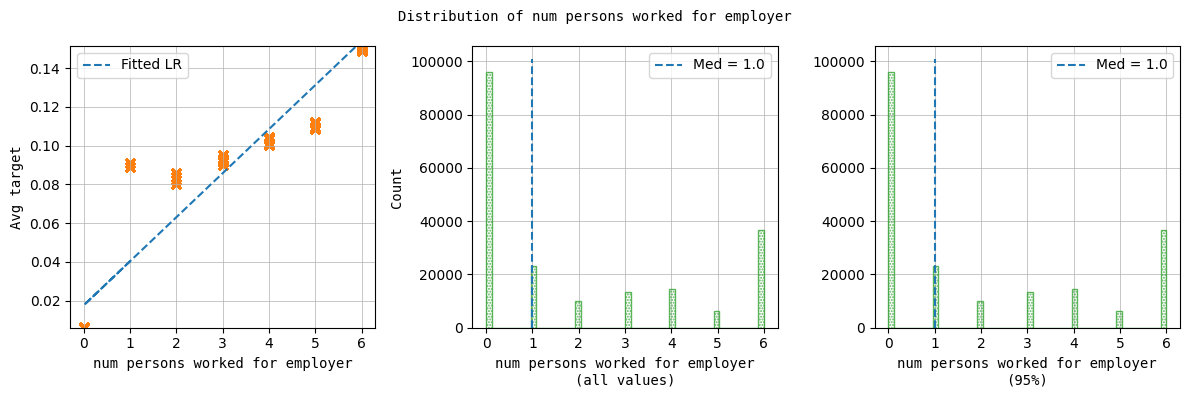

In [591]:
# 31. Num persons worked for employer
feature_name = 'num persons worked for employer'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`num persons worked for employer` looks like a continuous variable but with few unique integer values. It is rather loosely linearly correlated with the target. Since it has a countable number of values (like categories), we can also check if it is associated with the target.

Data type: int64
7 unique
0 nulls
--------------------


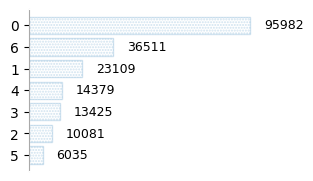

In [479]:
_ = describe(data[feature_name], 'cat')

In [480]:
run_chi2test(data[feature_name], data[target])

target                               0     1
num persons worked for employer             
0                                95386   596
1                                21016  2093
...                                ...   ...
5                                 5370   665
6                                31031  5480
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`num persons worked for employer` and `target` are _not_ independent


We have confirmed that `num persons worked for employer` and target are not independent indeed, thus we will use this feature in our model.

In [481]:
num_incl_cols.append(feature_name)

Data type: object
5 unique
0 nulls
--------------------


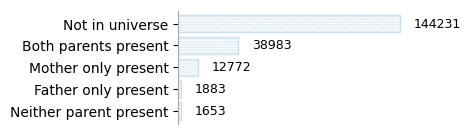

In [482]:
# 32. Family members under 18
feature_name = 'family members under 18'
_ = describe(data[feature_name], 'cat')

In [483]:
run_chi2test(data[feature_name], data[target])

target                        0      1
family members under 18               
Both parents present      38981      2
Father only present        1883      0
Mother only present       12772      0
Neither parent present     1653      0
Not in universe          131851  12380
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`family members under 18` and `target` are _not_ independent


We have confirmed that `family members under 18` and target are not independent indeed, thus we will use this feature in our model.

In [484]:
cat_incl_cols.append(feature_name)

Data type: object
42 unique
6713 nulls
--------------------


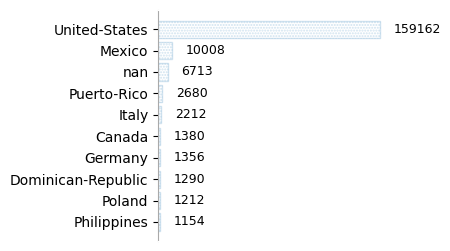

In [485]:
# 33. Country of birth father
feature_name = 'country of birth father'
_ = describe(data[feature_name], 'cat')

In [486]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                      0    1
country of birth father           
Cambodia                  191    5
Canada                   1250  130
...                       ...  ...
Vietnam                   446   11
Yugoslavia                202   15
--------------------
p_value = 1.86e-186 (alpha = 0.05)
`country of birth father` and `target` are _not_ independent


We have confirmed that `country of birth father` and target are not independent indeed, thus we will use this feature in our model.

In [487]:
cat_incl_cols.append(feature_name)

Data type: object
42 unique
6119 nulls
--------------------


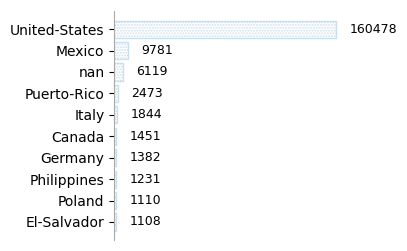

In [488]:
# 34. Country of birth mother
feature_name = 'country of birth mother'
_ = describe(data[feature_name], 'cat')

In [489]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                      0    1
country of birth mother           
Cambodia                  151    6
Canada                   1315  136
...                       ...  ...
Vietnam                   462   11
Yugoslavia                167   10
--------------------
p_value = 9.61e-181 (alpha = 0.05)
`country of birth mother` and `target` are _not_ independent


We have confirmed that `country of birth mother` and target are not independent indeed, thus we will use this feature in our model.

In [490]:
cat_incl_cols.append(feature_name)

Data type: object
42 unique
3393 nulls
--------------------


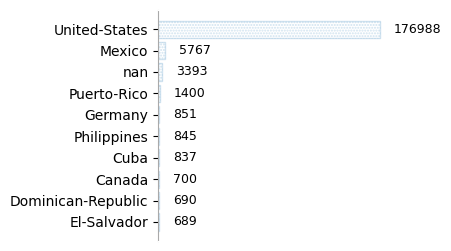

In [491]:
# 35. Country of birth self
feature_name = 'country of birth self'
_ = describe(data[feature_name], 'cat')

In [492]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                   0   1
country of birth self         
Cambodia                94   1
Canada                 631  69
...                    ...  ..
Vietnam                380  11
Yugoslavia              60   6
--------------------
p_value = 2.84e-128 (alpha = 0.05)
`country of birth self` and `target` are _not_ independent


We have confirmed that `country of birth self` and target are not independent indeed, thus we will use this feature in our model.

In [493]:
cat_incl_cols.append(feature_name)

Data type: object
5 unique
0 nulls
--------------------


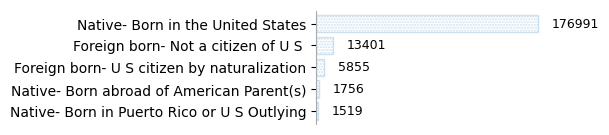

In [494]:
# 36. Citizenship
feature_name = 'citizenship'
_ = describe(data[feature_name], 'cat')

In [495]:
run_chi2test(data[feature_name], data[target])

target                                            0      1
citizenship                                               
Foreign born- Not a citizen of U S            12909    492
Foreign born- U S citizen by naturalization    5275    580
Native- Born abroad of American Parent(s)      1628    128
Native- Born in Puerto Rico or U S Outlying    1486     33
Native- Born in the United States            165842  11149
--------------------
p_value = 4.39e-71 (alpha = 0.05)
`citizenship` and `target` are _not_ independent


We have confirmed that `citizenship` and target are not independent indeed, thus we will use this feature in our model.

In [496]:
cat_incl_cols.append(feature_name)

Data type: int64
3 unique
0 nulls
--------------------


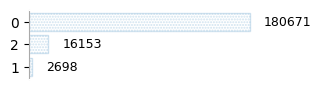

In [497]:
# 37. Own business or self employed
feature_name = 'own business or self employed'
_ = describe(data[feature_name], 'cat')

In [498]:
run_chi2test(data[feature_name], data[target])

target                              0      1
own business or self employed               
0                              170219  10452
1                                2089    609
2                               14832   1321
--------------------
p_value = 1.06e-305 (alpha = 0.05)
`own business or self employed` and `target` are _not_ independent


We have confirmed that `own business or self employed` and target are not independent indeed, thus we will use this feature in our model.

In [499]:
cat_incl_cols.append(feature_name)

Data type: object
3 unique
0 nulls
--------------------


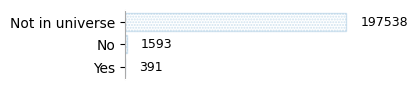

In [500]:
# 38. Fill inc questionnaire for veteran admin
feature_name = 'fill inc questionnaire for veteran admin'
_ = describe(data[feature_name], 'cat')

In [501]:
run_chi2test(data[feature_name], data[target])

target                                         0      1
fill inc questionnaire for veteran admin               
No                                          1378    215
Not in universe                           185387  12151
Yes                                          375     16
--------------------
p_value = 3.46e-33 (alpha = 0.05)
`fill inc questionnaire for veteran admin` and `target` are _not_ independent


We have confirmed that `fill inc questionnaire for veteran admin` and target are not independent indeed, thus we will use this feature in our model.

In [502]:
cat_incl_cols.append(feature_name)

Data type: int64
3 unique
0 nulls
--------------------


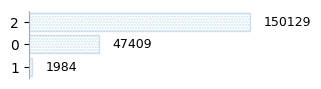

In [503]:
# 39. Veterans benefits
feature_name = 'veterans benefits'
_ = describe(data[feature_name], 'cat')

In [504]:
run_chi2test(data[feature_name], data[target])

target                  0      1
veterans benefits               
0                   47409      0
1                    1753    231
2                  137978  12151
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`veterans benefits` and `target` are _not_ independent


We have confirmed that `veterans benefits` and target are not independent indeed, thus we will use this feature in our model.

In [505]:
cat_incl_cols.append(feature_name)

Pearson corr coef = 0.96
Data type: int64
0 nulls
Min = 0.00
Max = 52.00
Mean = 23.18
Med = 8.00
Std = 24.41


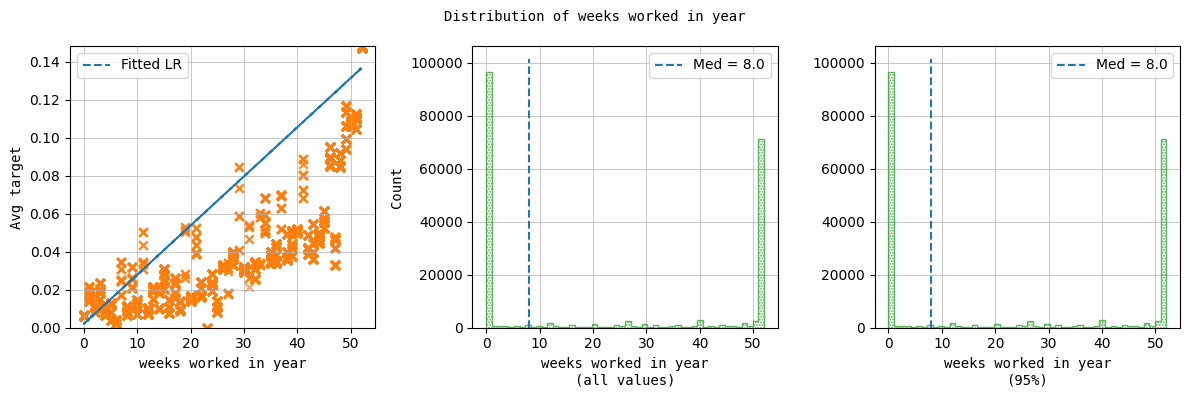

In [605]:
# 40. Weeks worked in year
feature_name = 'weeks worked in year'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Data type: int64
53 unique
0 nulls
--------------------


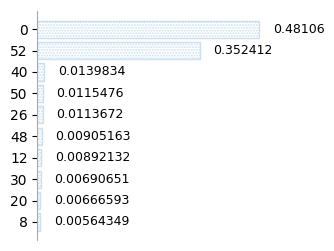

In [507]:
_ = describe(data[feature_name], 'cat', normalize=True)

`weeks worked in year` looks like a continuous variable. It is mostly takes the values of 0 and 52 weeks. Looks like, those who work more weeks, earn more too. We will use this feature in our model.

In [508]:
num_incl_cols.append(feature_name)

Data type: int64
2 unique
0 nulls
--------------------


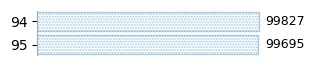

In [593]:
# 41. Year
feature_name = 'year'
_ = describe(data[feature_name], 'cat')

In [510]:
run_chi2test(data[feature_name], data[target])

target      0     1
year               
94      93988  5839
95      93152  6543
--------------------
p_value = 4.13e-11 (alpha = 0.05)
`year` and `target` are _not_ independent


`year` looks like an ordinal variable which is associated with the target, thus we will use this feature in our model.

In [512]:
ord_incl_cols.append(feature_name)

In [514]:
len(num_incl_cols) + len(num_excl_cols) + len(cat_incl_cols) + len(cat_excl_cols) + len(ord_incl_cols) + len(ord_excl_cols) == data.drop(columns=target).shape[1]

True

In [515]:
len(num_incl_cols + num_excl_cols)

7

In [516]:
len(cat_incl_cols + cat_excl_cols + ord_incl_cols + ord_excl_cols)

33

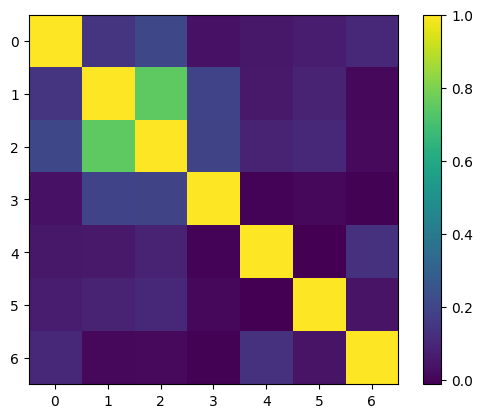

In [517]:
plt.imshow(data[num_incl_cols + num_excl_cols].corr())
plt.colorbar();

In [531]:
data.groupby('year')[target].mean()

year
94    0.058491
95    0.065630
Name: target, dtype: float64

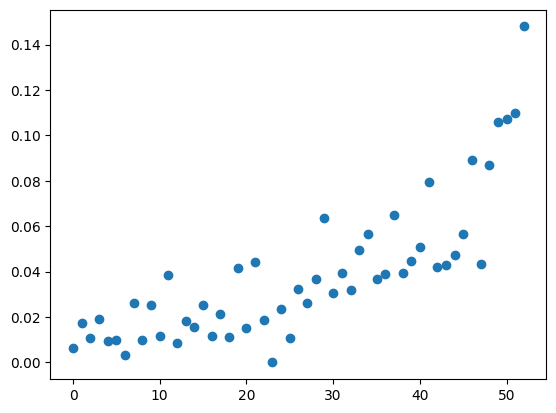

In [570]:
plt.scatter(data['weeks worked in year'].value_counts().sort_index().index, data.groupby('weeks worked in year')[target].mean());

In [529]:
data[data['weeks worked in year'] == 52][target].value_counts(normalize=True)

target
0    0.851992
1    0.148008
Name: proportion, dtype: float64

In [549]:
target_enc = TargetEncoder()
target_enc.fit_transform(data['weeks worked in year'].values.reshape(-1, 1), data[target]).shape

(199522, 1)

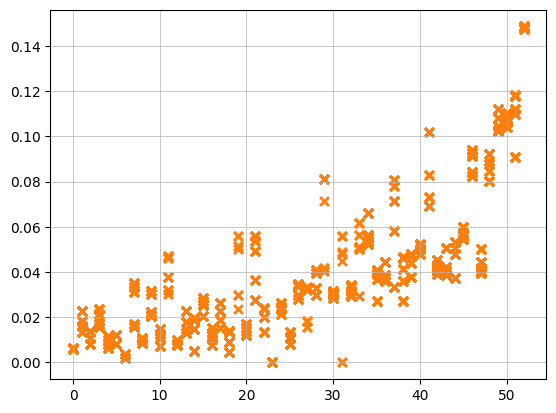

In [571]:
plt.scatter(data['weeks worked in year'], target_enc.fit_transform(data['weeks worked in year'].values.reshape(-1, 1), data[target]), color='C1', marker='x')
plt.grid(lw=0.5);

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
#temp = CatBoostClassifier()
temp = HistGradientBoostingClassifier(categorical_features=[0, 1])
temp.fit(data[['sex', 'education']].fillna('Unknown'), data[target])

ValueError: could not convert string to float: 'Male'

In [ ]:
temp.predict_proba(['Male', 'Children'])

array([9.99950236e-01, 4.97642991e-05])

In [ ]:
print(data[['sex', 'education', target]].value_counts().to_string())

sex     education                               target
Female  High school graduate                    0         26564
Male    Children                                0         24077
Female  Children                                0         23345
Male    High school graduate                    0         19963
Female  Some college but no degree              0         14605
Male    Some college but no degree              0         11428
Female  Bachelors degree(BA AB BS)              0          9046
Male    Bachelors degree(BA AB BS)              0          6904
Female  7th and 8th grade                       0          4149
        10th grade                              0          4067
Male    7th and 8th grade                       0          3786
Female  11th grade                              0          3631
Male    10th grade                              0          3428
Female  9th grade                               0          3274
Male    11th grade                              0

### <a id="data-preprocessing"></a>[25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)

In [ ]:
# Check nulls
data.isna().sum() / data.shape[0]

* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding

* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

### <a id="model-training"></a>[25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)

* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models

* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### <a id="summary"></a>[25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?

* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)

* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero